# Read data

In [3]:
import numpy as np # linear algebra
import pandas as pd # data processing, CSV file I/O (e.g. pd.read_csv)

import seaborn as sns # Visualization
import matplotlib.pyplot as plt # Visualization

from sklearn.metrics import mean_absolute_error, mean_squared_error
import math

import warnings # Supress warnings
warnings.filterwarnings('ignore')

df = pd.read_csv("./files/Aquifer_Petrignano.csv")

### Simplifications for the sake of the tutorial ###
# Drop data before 2009 for the purpose of this tutorial
df = df[df.Rainfall_Bastia_Umbra.notna()].reset_index(drop=True)
# Drop one of the target columns, so we can focus on only one target
df = df.drop(['Depth_to_Groundwater_P24', 'Temperature_Petrignano'], axis=1)

# Simplify column names
df.columns = ['Date', 'Rainfall', 'Depth_to_Groundwater', 'Temperature', 'Drainage_Volume', 'River_Hydrometry']

targets = ['Depth_to_Groundwater']
features = [feature for feature in df.columns if feature not in targets]
df.head()

,Date,Rainfall,Depth_to_Groundwater,Temperature,Drainage_Volume,River_Hydrometry
0,01/01/2009,0.0,-31.14,5.2,-24530.688,2.4
1,02/01/2009,0.0,-31.11,2.3,-28785.888,2.5
2,03/01/2009,0.0,-31.07,4.4,-25766.208,2.4
3,04/01/2009,0.0,-31.05,0.8,-27919.296,2.4
4,05/01/2009,0.0,-31.01,-1.9,-29854.656,2.3


In [4]:
from datetime import datetime, date

df['Date'] = pd.to_datetime(df.Date, format = '%d/%m/%Y')

# Plot data

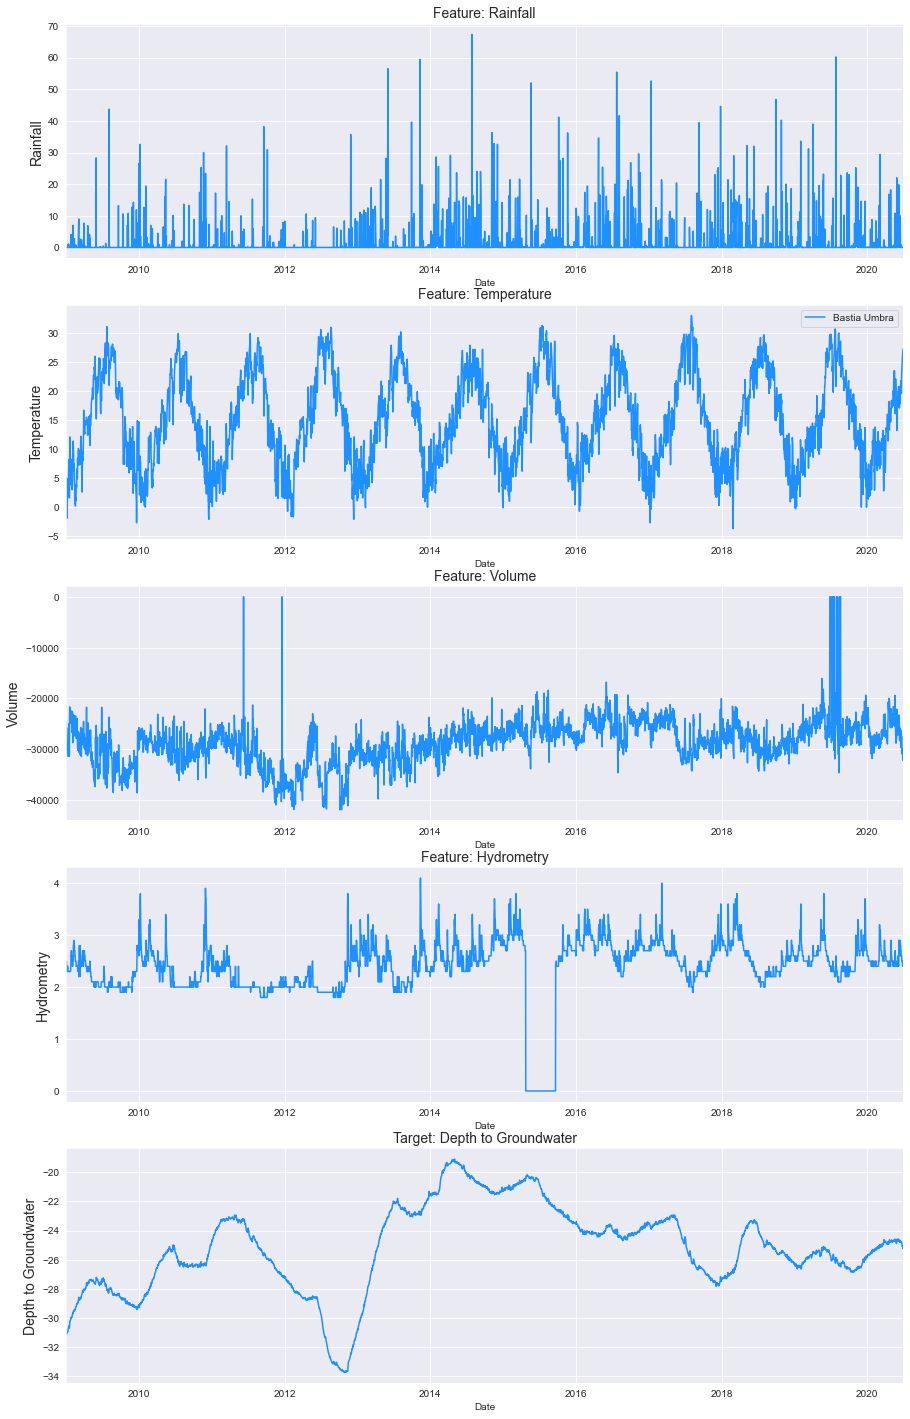

In [5]:
f, ax = plt.subplots(nrows=5, ncols=1, figsize=(15, 25))

sns.lineplot(x=df.Date, y=df.Rainfall.fillna(np.inf), ax=ax[0], color='dodgerblue')
ax[0].set_title('Feature: Rainfall', fontsize=14)
ax[0].set_ylabel(ylabel='Rainfall', fontsize=14)


sns.lineplot(x=df.Date, y=df.Temperature.fillna(np.inf), ax=ax[1], color='dodgerblue',label='Bastia Umbra')
ax[1].set_title('Feature: Temperature', fontsize=14)
ax[1].set_ylabel(ylabel='Temperature', fontsize=14)


sns.lineplot(x=df.Date, y=df.Drainage_Volume.fillna(np.inf), ax=ax[2], color='dodgerblue')
ax[2].set_title('Feature: Volume', fontsize=14)
ax[2].set_ylabel(ylabel='Volume', fontsize=14)


sns.lineplot(x=df.Date, y=df.River_Hydrometry.fillna(np.inf), ax=ax[3], color='dodgerblue')
ax[3].set_title('Feature: Hydrometry', fontsize=14)
ax[3].set_ylabel(ylabel='Hydrometry', fontsize=14)


sns.lineplot(x=df.Date, y=df.Depth_to_Groundwater.fillna(np.inf), ax=ax[4], color='dodgerblue')
ax[4].set_title('Target: Depth to Groundwater', fontsize=14)
ax[4].set_ylabel(ylabel='Depth to Groundwater', fontsize=14)


for i in range(5):
    ax[i].set_xlim([date(2009, 1, 1), date(2020, 6, 30)])

plt.show()

# Fix missing data

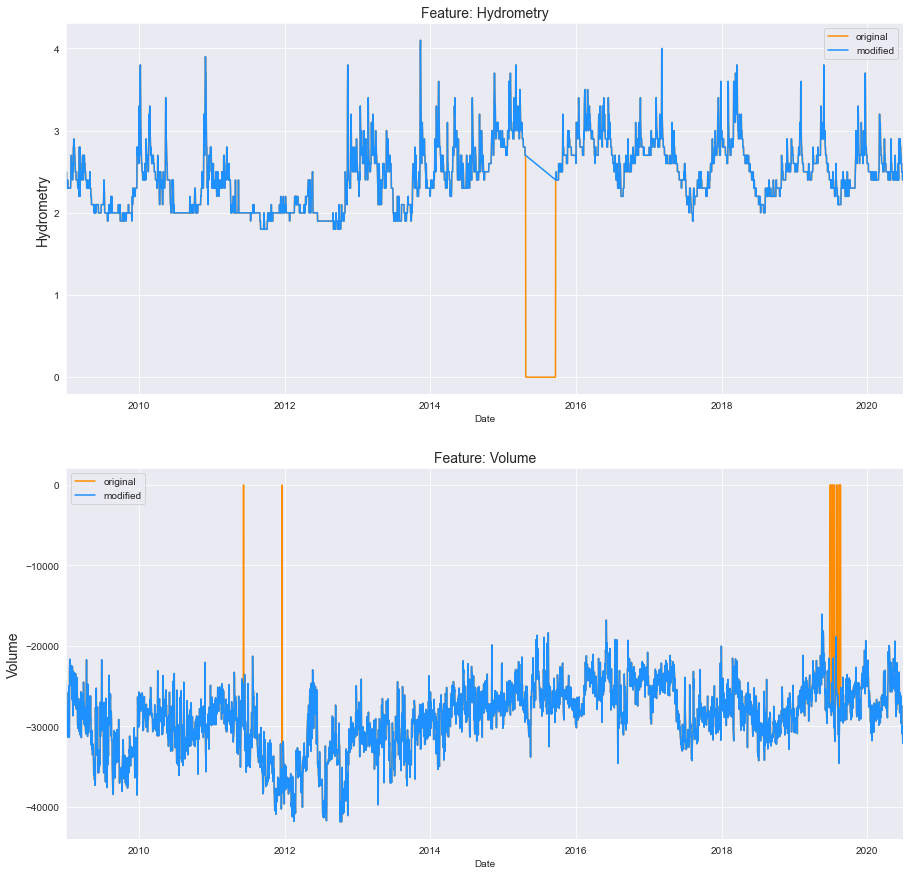

In [6]:
f, ax = plt.subplots(nrows=2, ncols=1, figsize=(15, 15))
old = df.River_Hydrometry.copy()
df['River_Hydrometry'] = np.where((df.River_Hydrometry == 0),np.nan, df.River_Hydrometry)

sns.lineplot(x=df.Date, y=old.fillna(np.inf), ax=ax[0], color='darkorange', label = 'original')
sns.lineplot(x=df.Date, y=df.River_Hydrometry.fillna(np.inf), ax=ax[0], color='dodgerblue', label = 'modified')
ax[0].set_title('Feature: Hydrometry', fontsize=14)
ax[0].set_ylabel(ylabel='Hydrometry', fontsize=14)

old = df.Drainage_Volume.copy()
df['Drainage_Volume'] = np.where((df.Drainage_Volume == 0),np.nan, df.Drainage_Volume)

sns.lineplot(x=df.Date, y=old.fillna(np.inf), ax=ax[1], color='darkorange', label = 'original')
sns.lineplot(x=df.Date, y=df.Drainage_Volume.fillna(np.inf), ax=ax[1], color='dodgerblue', label = 'modified')
ax[1].set_title('Feature: Volume', fontsize=14)
ax[1].set_ylabel(ylabel='Volume', fontsize=14)


for i in range(2):
    ax[i].set_xlim([date(2009, 1, 1), date(2020, 6, 30)])

plt.show()

In [7]:
df['Drainage_Volume'] = df['Drainage_Volume'].interpolate()
df['River_Hydrometry'] = df['River_Hydrometry'].interpolate()
df['Depth_to_Groundwater'] = df['Depth_to_Groundwater'].interpolate()

# Resample data to weekly basis

In [8]:
df_downsampled = df[['Date',
                     'Depth_to_Groundwater',
                     'Temperature',
                     'Drainage_Volume',
                     'River_Hydrometry'
                     ]].resample('7D', on='Date').mean().reset_index(drop=False)

df_downsampled['Rainfall'] = df[['Date',
                                 'Rainfall'
                                 ]].resample('7D', on='Date').sum().reset_index(drop=False)[['Rainfall']]



In [9]:
uni = df_downsampled.drop(['Rainfall', 'Temperature', 'Drainage_Volume', 'River_Hydrometry'], axis=1)
print(uni.tail(10))


          Date  Depth_to_Groundwater
590 2020-04-23            -24.738571
591 2020-04-30            -24.705714
592 2020-05-07            -24.714286
593 2020-05-14            -24.671429
594 2020-05-21            -24.785714
595 2020-05-28            -24.697143
596 2020-06-04            -24.638571
597 2020-06-11            -24.751429
598 2020-06-18            -24.822857
599 2020-06-25            -25.145000


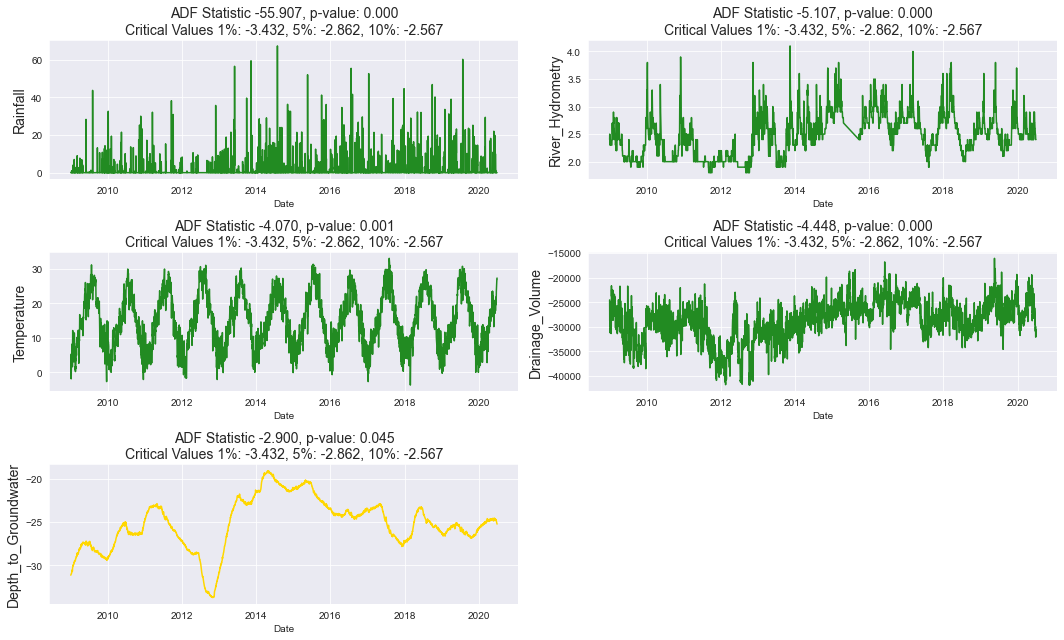

In [10]:
from statsmodels.tsa.stattools import adfuller
f, ax = plt.subplots(nrows=3, ncols=2, figsize=(15, 9))

def visualize_adfuller_results(series, title, ax):
    result = adfuller(series)
    significance_level = 0.05
    adf_stat = result[0]
    p_val = result[1]
    crit_val_1 = result[4]['1%']
    crit_val_5 = result[4]['5%']
    crit_val_10 = result[4]['10%']

    if (p_val < significance_level) & ((adf_stat < crit_val_1)):
        linecolor = 'forestgreen'
    elif (p_val < significance_level) & (adf_stat < crit_val_5):
        linecolor = 'gold'
    elif (p_val < significance_level) & (adf_stat < crit_val_10):
        linecolor = 'orange'
    else:
        linecolor = 'indianred'
    sns.lineplot(x=df.Date, y=series, ax=ax, color=linecolor)
    ax.set_title(f'ADF Statistic {adf_stat:0.3f}, p-value: {p_val:0.3f}\nCritical Values 1%: {crit_val_1:0.3f}, 5%: {crit_val_5:0.3f}, 10%: {crit_val_10:0.3f}', fontsize=14)
    ax.set_ylabel(ylabel=title, fontsize=14)

visualize_adfuller_results(df.Rainfall.values, 'Rainfall', ax[0, 0])
visualize_adfuller_results(df.Temperature.values, 'Temperature', ax[1, 0])
visualize_adfuller_results(df.River_Hydrometry.values, 'River_Hydrometry', ax[0, 1])
visualize_adfuller_results(df.Drainage_Volume.values, 'Drainage_Volume', ax[1, 1])
visualize_adfuller_results(df.Depth_to_Groundwater.values, 'Depth_to_Groundwater', ax[2, 0])

f.delaxes(ax[2, 1])
plt.tight_layout()
plt.show()

# ARIMA model

In [11]:
from pmdarima import auto_arima
stepwise_fit = auto_arima(uni['Depth_to_Groundwater'], trace=True,
                          suppress_warnings=True)

Performing stepwise search to minimize aic
 ARIMA(2,1,2)(0,0,0)[0] intercept   : AIC=-747.055, Time=1.15 sec
 ARIMA(0,1,0)(0,0,0)[0] intercept   : AIC=-338.822, Time=0.30 sec
 ARIMA(1,1,0)(0,0,0)[0] intercept   : AIC=-679.117, Time=0.26 sec
 ARIMA(0,1,1)(0,0,0)[0] intercept   : AIC=-532.856, Time=0.29 sec
 ARIMA(0,1,0)(0,0,0)[0]             : AIC=-339.063, Time=0.09 sec
 ARIMA(1,1,2)(0,0,0)[0] intercept   : AIC=-749.048, Time=1.21 sec
 ARIMA(0,1,2)(0,0,0)[0] intercept   : AIC=-598.943, Time=0.45 sec
 ARIMA(1,1,1)(0,0,0)[0] intercept   : AIC=-751.040, Time=0.48 sec
 ARIMA(2,1,1)(0,0,0)[0] intercept   : AIC=-749.047, Time=1.77 sec
 ARIMA(2,1,0)(0,0,0)[0] intercept   : AIC=-725.441, Time=0.53 sec
 ARIMA(1,1,1)(0,0,0)[0]             : AIC=-752.905, Time=0.31 sec
 ARIMA(0,1,1)(0,0,0)[0]             : AIC=-533.737, Time=0.13 sec
 ARIMA(1,1,0)(0,0,0)[0]             : AIC=-680.777, Time=0.12 sec
 ARIMA(2,1,1)(0,0,0)[0]             : AIC=-750.907, Time=0.52 sec
 ARIMA(1,1,2)(0,0,0)[0]          

In [12]:
print(df.shape)
train=df.iloc[:-10]
test=df.iloc[-10:]
print(train.shape,test.shape)

(4199, 6)
(4189, 6) (10, 6)


In [13]:
from statsmodels.tsa.arima.model import ARIMA
model=ARIMA(train['Depth_to_Groundwater'],order=(1,1,1))
model=model.fit()
model.summary()

<class 'statsmodels.iolib.summary.Summary'>
"""
                                SARIMAX Results                                 
================================================================================
Dep. Variable:     Depth_to_Groundwater   No. Observations:                 4189
Model:                   ARIMA(1, 1, 1)   Log Likelihood                5650.874
Date:                  Mon, 03 Jul 2023   AIC                         -11295.747
Time:                          12:07:49   BIC                         -11276.727
Sample:                               0   HQIC                        -11289.021
                                 - 4189                                         
Covariance Type:                    opg                                         
==============================================================================
                 coef    std err          z      P>|z|      [0.025      0.975]
------------------------------------------------------------------------------
ar.L1         -0.1251      0.073     -1.713      0.087      -0.268       0.018
ma.L1          0.3126      0.071      4.395      0.000       0.173       0.452
sigma2         0.0039   6.58e-05     59.889      0.000       0.004       0.004
===================================================================================
Ljung-Box (L1) (Q):                   0.00   Jarque-Bera (JB):               401.86
Prob(Q):                              0.97   Prob(JB):                         0.00
Heteroskedasticity (H):               1.29   Skew:                             0.26
Prob(H) (two-sided):                  0.00   Kurtosis:                         4.43
===================================================================================

Warnings:
[1] Covariance matrix calculated using the outer product of gradients (complex-step).
"""

<AxesSubplot:>

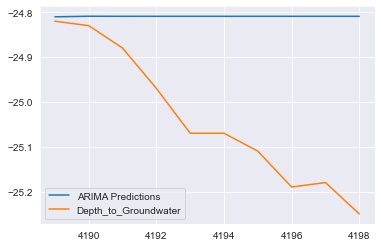

In [14]:
start=len(train)
end=len(train)+len(test)-1
pred=model.predict(start=start,end=end,typ='levels').rename('ARIMA Predictions')
pred.plot(legend=True)
test['Depth_to_Groundwater'].plot(legend=True)

In [15]:
from sklearn.metrics import mean_squared_error
from math import sqrt
test['Depth_to_Groundwater'].mean()
rmse=sqrt(mean_squared_error(pred,test['Depth_to_Groundwater']))
print(rmse)

0.27111714535080844


# LSTM

In [16]:
print(uni['Date'])


0     2009-01-01
1     2009-01-08
2     2009-01-15
3     2009-01-22
4     2009-01-29
         ...    
595   2020-05-28
596   2020-06-04
597   2020-06-11
598   2020-06-18
599   2020-06-25
Name: Date, Length: 600, dtype: datetime64[ns]


In [17]:
import datetime as dt

datetime_to_timestamp = lambda d: (d - dt.datetime(1970, 1, 1)).total_seconds()
timestamps = np.array([datetime_to_timestamp(d) for d in uni['Date']])
print(timestamps)

[1.2307680e+09 1.2313728e+09 1.2319776e+09 1.2325824e+09 1.2331872e+09
 1.2337920e+09 1.2343968e+09 1.2350016e+09 1.2356064e+09 1.2362112e+09
 1.2368160e+09 1.2374208e+09 1.2380256e+09 1.2386304e+09 1.2392352e+09
 1.2398400e+09 1.2404448e+09 1.2410496e+09 1.2416544e+09 1.2422592e+09
 1.2428640e+09 1.2434688e+09 1.2440736e+09 1.2446784e+09 1.2452832e+09
 1.2458880e+09 1.2464928e+09 1.2470976e+09 1.2477024e+09 1.2483072e+09
 1.2489120e+09 1.2495168e+09 1.2501216e+09 1.2507264e+09 1.2513312e+09
 1.2519360e+09 1.2525408e+09 1.2531456e+09 1.2537504e+09 1.2543552e+09
 1.2549600e+09 1.2555648e+09 1.2561696e+09 1.2567744e+09 1.2573792e+09
 1.2579840e+09 1.2585888e+09 1.2591936e+09 1.2597984e+09 1.2604032e+09
 1.2610080e+09 1.2616128e+09 1.2622176e+09 1.2628224e+09 1.2634272e+09
 1.2640320e+09 1.2646368e+09 1.2652416e+09 1.2658464e+09 1.2664512e+09
 1.2670560e+09 1.2676608e+09 1.2682656e+09 1.2688704e+09 1.2694752e+09
 1.2700800e+09 1.2706848e+09 1.2712896e+09 1.2718944e+09 1.2724992e+09
 1.273

In [18]:
uni_timestamp = uni.copy()
uni_timestamp['Date'] = timestamps
print(uni_timestamp)
uni_timestamp.dtypes

             Date  Depth_to_Groundwater
0    1.230768e+09            -31.048571
1    1.231373e+09            -30.784286
2    1.231978e+09            -30.420000
3    1.232582e+09            -30.018571
4    1.233187e+09            -29.790000
..            ...                   ...
595  1.590624e+09            -24.697143
596  1.591229e+09            -24.638571
597  1.591834e+09            -24.751429
598  1.592438e+09            -24.822857
599  1.593043e+09            -25.145000

[600 rows x 2 columns]


Date                    float64
Depth_to_Groundwater    float64
dtype: object

In [19]:
uni_notimestamp = uni.drop(['Date'], axis=1)
train=uni_notimestamp.iloc[:-10]
test=uni_notimestamp.iloc[-10:]

In [20]:
from sklearn.preprocessing import MinMaxScaler
scaler = MinMaxScaler()
scaler.fit(train)
scaled_train = scaler.transform(train)
scaled_test = scaler.transform(test)

In [21]:
scaled_train[:10]

array([[0.18203356],
       [0.20029615],
       [0.2254689 ],
       [0.25320829],
       [0.26900296],
       [0.28746298],
       [0.2976308 ],
       [0.31589339],
       [0.33109576],
       [0.34471866]])

In [22]:
!pip install packages

Defaulting to user installation because normal site-packages is not writeable


In [23]:
from keras.preprocessing.sequence import TimeseriesGenerator
n_input = 52
n_features = 1
generator = TimeseriesGenerator(scaled_train, scaled_train, length=n_input, batch_size=1)

ImportError: cannot import name 'builder' from 'google.protobuf.internal' (C:\Users\poeppelmann\AppData\Roaming\Python\Python39\site-packages\google\protobuf\internal\__init__.py)

In [ ]:
X,y = generator[0]
print(f'Given the Array: \n{X.flatten()}')
print(f'Predict this y: \n {y}')